Is it a bird?

In [ ]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

Step 1: Download images of birds and non-birds

In [26]:
from duckduckgo_search import DDGS
from fastcore.all import *

# Using lite backend and limit the number of results
from itertools import islice

ddgs = DDGS()

def search_images(term, max_images = 30):
    print(f"searching for '{term}'")
    keywords = term
    ddgs_images = ddgs.images(keywords)
    limited_images = list(islice(ddgs_images, max_images))
    return L(limited_images).itemgot('image')

In [29]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('tiger photos', max_images=1)
urls[0]

searching for 'tiger photos'


'https://images.pexels.com/photos/64152/tiger-cub-tiger-cub-big-cat-64152.jpeg?cs=srgb&dl=animal-animal-photography-close-up-64152.jpg&fm=jpg'

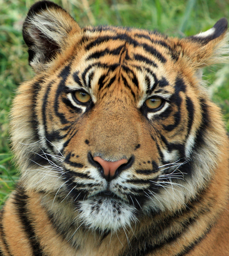

In [30]:
from fastdownload import download_url
dest = 'tiger.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

searching for 'cat photos'


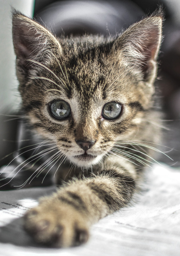

In [31]:
download_url(search_images('cat photos', max_images=1)[0], 'cat.jpg', show_progress=False)
Image.open('cat.jpg').to_thumb(256,256)

In [33]:
searches = 'cat','tiger'
path = Path('cat_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

searching for 'cat photo'
searching for 'cat sun photo'
searching for 'cat shade photo'
searching for 'tiger photo'
searching for 'tiger sun photo'
searching for 'tiger shade photo'


In [34]:
print(path)
searches = 'cat','tiger'

for imageType in searches:
    print(imageType)
    content = os.listdir(path/imageType)
    for element in content:
        print(element)

cat_or_not
cat
e1b82006-e413-495e-86a9-5dd08d9f966c.jpg
caf2311a-d228-4164-89e9-019387dcdece.jpg
53221223-4a14-4e87-b488-a83f73e612b6.jpg
2aeac07e-fc05-4a93-8d5b-85c25490bd79.jpg
9a73c9b3-e321-4364-9318-4ddfbeee73f4.jpg
cb280d50-389c-486a-9763-0526a260948c.jpg
66c13818-4e46-4214-acf6-10197ec35794.jpg
f162623d-e996-4dab-8fee-54edc1defd01.jpg
cd0c0f29-dfc5-4c93-b7c9-d6627cf16c63.jpg
3dae46d6-9713-49de-a7f6-405074557857.jpg
18f9d73c-9281-4cbe-9c98-8cd5f42e052a.jpg
b8e39081-8ad2-43ef-9f75-0055da6fcc09.jpg
b5fc7b46-37d5-4410-bb2b-4e92a5fef87f.jpg
7f51bf0b-362b-49a5-9e7c-81a476066478.jpg
5e24905e-4a2e-4d36-b457-472dbf9184b8.jpg
795269fa-2894-4319-918e-c56ec7762260.jpg
f2a7b08b-294c-4815-b451-7d8848f32f9d.jpg
eef8f25b-0e14-4c9b-bc3d-aa05e1373427.jpg
1c28225a-0208-4a15-81ed-fe879ef6b33d.jpg
dd6c5410-b92b-4443-bca7-c6ed6e4a3a7b.jpg
eb116ad8-6da6-40c1-b897-f4dabba32db5.jpg
b27e60a9-3757-4b3a-814c-f14f29446a05.jpg
df7d5c16-01b1-41c3-88d8-90ef3ed74364.JPG
12f867bb-0223-4e27-9206-ba49fa0a1dac.jpg
6

Step 2: Train our model

In [35]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

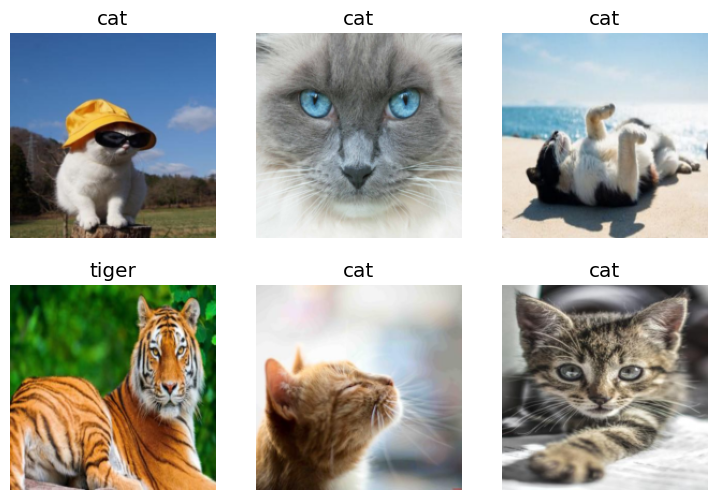

In [36]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [37]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/ditthaponglakagul/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 11.2MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.939134,0.341276,0.096774,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.296919,0.204929,0.064516,00:02
1,0.192543,0.138512,0.064516,00:01
2,0.131853,0.112459,0.064516,00:01


Step 3: Use our model (and build your own!)

In [38]:
is_cat,_,probs = learn.predict(PILImage.create('cat.jpg'))
print(f"This is a: {is_cat}.")
print(f"Probability it's a cat: {probs[0]:.4f}")

This is a: cat.
Probability it's a cat: 0.9942
